In [103]:
import control
import os
import torch

import numpy as np

from tensordict import TensorDict
from torchrl.envs.utils import check_env_specs, set_exploration_mode

from matplotlib import pyplot as plt

from custom_environment import controllable_linear_system, SystemEnvironment
from loading import init_environment, load_config, load_model


TODO 
- [ ] write out the equations of a linear system and the same for the discrete linear system; mention the characteristic polynomial
- [ ] implement env here
- [ ] explain the methods that have to be overwritten
- [ ] explain specs; limiting actions makes sense
- [ ] implement in numpy but say that we could have done it in torch but for the sake of the example let's do it in numpy
- [ ] explain how the difference between the control lib output and the environment output is due to the discretization and it's exactly what we expect to see. We choose a larger timestep because it makes the environment simulation faster while training.

### Create the system environment

In [104]:
dt = 1e-1  # sec; the sampling period

# side note: f = 1/dt should be 10 to 40 times larger than the natural frequency fn of the system(open loop I think) which in out case
# boils down to fn = sqrt(a[0]) / 2 / pi

A, B, C, D = controllable_linear_system(a=(0.5, 1)) # get system matrices

env = SystemEnvironment(A, B, C, D, dt) # create environment object
check_env_specs(env) # check if the specs match the output of the environment

Let's check if out environment behaves as expected.


Transfer function
 
      1
-------------
s^2 + s + 0.5



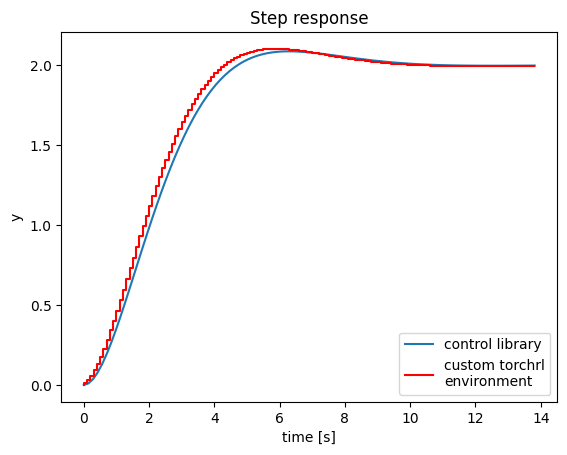

In [105]:
sys = control.ss(A, B, C, D)

transfer_func = control.tf(sys)

print("\nTransfer function\n", transfer_func)

time_axis, y_out = control.step_response(sys)

env_time_axis = np.arange(start=0, step=env.dt, stop=time_axis[-1])

# apply a unit step function to the system
rollout = env.rollout(len(env_time_axis), policy=lambda _: TensorDict({"action": 1.0}, batch_size=torch.Size()))

# extract the system output 
y_env = env.C @ rollout["next"]["observation"].cpu().numpy().T
y_env = y_env.flatten()


plt.figure()
plt.title("Step response")
plt.plot(time_axis, y_out, label="control library")
plt.step(env_time_axis, y_env, color="r", label='custom torchrl\nenvironment')
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("y")
plt.show()

### Evaluate a policy trained on this environment

Training a policy is out of the scope of this example(for that see the tutorial on PPO) but let's see what a result of a previously trained policy looks like. The goal of the policy was to reach a reference value of 1. We can see that we were able to learn a policy for our custom environment using the same workflow as for the environments that come with the package. 

TODO
- [ ] leave out the code and just put the picture in; the code with lots of helper functions will confuse

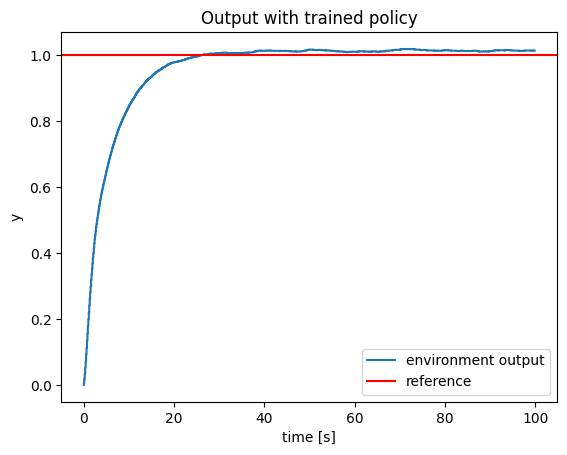

In [106]:
filepath = os.path.join("LinearSystem", "ppo", "example_trained_model.p")
config = load_config(filepath)

env = init_environment(config)

env.transform[0].loc = config["loc"].to(config["device"])
env.transform[0].scale = config["scale"].to(config["device"])

policy_module, _ = load_model(filepath, env)

with set_exploration_mode("mean"), torch.no_grad():
    # execute a rollout with the trained policy
    eval_rollout = env.rollout(config["max_eval_steps"], policy_module)

states = eval_rollout["next"]["observation"].cpu().numpy().T
states -= config["loc"].cpu().numpy()[:, np.newaxis]
states /= config["scale"].cpu().numpy()[:, np.newaxis]
y_env = env.C @ states
y_env = y_env.flatten()

env_time_axis = np.arange(start=0, step=env.dt, stop=len(y_env) * env.dt)

plt.figure()
plt.title("Output with trained policy")
plt.step(env_time_axis, y_env, label='environment output')
plt.axhline(env.ref, color='r', label='reference')
plt.xlabel("time [s]")
plt.ylabel("y")
plt.legend()

plt.show()